In [1]:
import os
import zipfile
import pydicom
import matplotlib.pyplot as plt
import pandas as pd

# Paths
#dicom_zip_path = r"Z:\AUG_FL_Projekte_DB\FRB\FRB Austria - AI-based Analysis of Real-World Retina\12_Data\06_Data files\02_EXPORT OCT\01_2442_DICOM.zip"
#csv_file_path = r"Z:\AUG_FL_Projekte_DB\FRB\FRB Austria - AI-based Analysis of Real-World Retina\12_Data\06_Data files\03_FRB DATA\01_2442_MACULAR_Visit_Export_2020-11-23.csv"
#temp_extract_path = r"Z:\AUG_FL_Projekte_DB\temp_dicom_extraction"
# Define Base Paths:
dicom_zip_path = r"C:\Users\camil\Downloads\Test_data_OCT\Zip_patients_DICOM"
e2e_zip_path = r"C:\Users\camil\Downloads\Test_data_OCT\Zip_patients_E2E"
csv_file_path = r"C:\Users\camil\Downloads\Test_data_OCT"
temp_extract_path = r"C:\Users\camil\Downloads\Test_data_OCT\temp_dicom_extraction"

In [2]:
# Step 1: Extract ZIP files for multiple patients
zip_files = [f for f in os.listdir(dicom_zip_path) if f.endswith('.zip')]

if not zip_files:
    print("No ZIP files found.")
else:
    print(f"Found {len(zip_files)} ZIP files. Extracting...")

for zip_file in zip_files:
    patient_zip_path = os.path.join(dicom_zip_path, zip_file)
    patient_extract_path = os.path.join(temp_extract_path, zip_file.replace('.zip', ''))

    if not os.path.exists(patient_extract_path):
        os.makedirs(patient_extract_path)

    with zipfile.ZipFile(patient_zip_path, 'r') as zip_ref:
        zip_ref.extractall(patient_extract_path)
    print(f"Extracted: {zip_file} to {patient_extract_path}")

Found 4 ZIP files. Extracting...
Extracted: 01_2442_DICOM.zip to C:\Users\camil\Downloads\Test_data_OCT\temp_dicom_extraction\01_2442_DICOM
Extracted: 02_2576_DICOM.zip to C:\Users\camil\Downloads\Test_data_OCT\temp_dicom_extraction\02_2576_DICOM
Extracted: 03_TEST_DICOM.zip to C:\Users\camil\Downloads\Test_data_OCT\temp_dicom_extraction\03_TEST_DICOM
Extracted: 04_4545_DICOM.zip to C:\Users\camil\Downloads\Test_data_OCT\temp_dicom_extraction\04_4545_DICOM


### Folder structure directory: 

```plaintext
00_PatientID_DICOM/
    DICOM/
        MCXX/
            Visit1/
                Series1/
                    0CT00.dcm
                Series2/
                    OCT01.dcm
01_PatientID_DICOM/                   
    DICOM/ 
        MCXX/
            Visit1/
                Series1/
                    OCT00.dcm
                Series2/
                    etc...
```

In [3]:
# Step 2: Process each patient's extracted folder
for patient_folder in os.listdir(temp_extract_path):
    patient_path = os.path.join(temp_extract_path, patient_folder)

    # Handle the nested folder structure: 01_XXXX_DICOM/01_XXXXX_DICOM/DICOM
    nested_folders = [os.path.join(patient_path, subfolder) for subfolder in os.listdir(patient_path)]
    for nested_folder in nested_folders:
        dicom_base_path = os.path.join(nested_folder, "DICOM")

        if not os.path.exists(dicom_base_path):
            print(f"Skipping: {nested_folder} (No DICOM data found)")
            continue

        # Recursively find all DICOM files under the DICOM directory
        dicom_files = []
        for root, _, files in os.walk(dicom_base_path):
            for file in files:
                #if file.endswith('.dcm'):
                dicom_files.append(os.path.join(root, file))

        if not dicom_files:
            print(f"Skipping: {nested_folder} (No DICOM files found under 'DICOM')")
            continue

        print(f"\nProcessing patient: {patient_folder}, found {len(dicom_files)} DICOM files.")

        # Display metadata and visualize the first few scans
        for i, dicom_file in enumerate(dicom_files[:3]):  # Limit visualization to the first 3 files
            try:
                ds = pydicom.dcmread(dicom_file)

                # Metadata
                print(f"\n--- Metadata for file {dicom_file} ---")
                print(ds)
                '''
                # Visualize scan if pixel data is available
                if hasattr(ds, 'pixel_array'):
                    plt.figure(figsize=(6, 6))
                    plt.imshow(ds.pixel_array, cmap='gray')
                    plt.title(f"Patient: {patient_folder}, Scan {i+1}")
                    plt.axis('off')
                    plt.show()
                else:
                    print(f"File {dicom_file} does not contain pixel data.")
                '''
            except Exception as e:
                print(f"Error reading DICOM file {dicom_file}: {e}")


Processing patient: 01_2442_DICOM, found 300 DICOM files.

--- Metadata for file C:\Users\camil\Downloads\Test_data_OCT\temp_dicom_extraction\01_2442_DICOM\01_2442_DICOM\DICOM\MC1\900\16100\106601\00000002 ---
Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 178
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Ophthalmic Tomography Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.33437.11.4.442894.51140542266583.15108.4.1
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.30.3
(0002, 0013) Implementation Version Name         SH: '3.00'
-------------------------------------------------
(0008, 0000) Group Length                        UL: 580
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                 

In [5]:
# Step 2: Prepare DataFrame to store metadata
# Initialize a dictionary to store the count of volumetric OCT scans per patient
volumetric_scan_count = {}
columns = [
    "Patient Folder", "Visit", "Scan Folder", "Image Type", "Manufacturer", "Model Name",
    "Patient Sex", "Patient's Birth Date", "Laterality", "Study Date", "Study Description",
    "Series Description", "Modality", "Image Shape", "File Path"
]
metadata_table = pd.DataFrame(columns=columns)

# Step 3: Process each patient's extracted folder
for patient_folder in os.listdir(temp_extract_path):
    patient_path = os.path.join(temp_extract_path, patient_folder, patient_folder)
    print(patient_path)

    # Ensure patient folder has expected structure
    dicom_base_path = os.path.join(patient_path, "DICOM")
    if not os.path.exists(dicom_base_path):
        print(f"Skipping: {patient_folder} (No DICOM data found)")
        continue

    # Get all visit folders (two levels under "DICOM")
    visits = [
        os.path.join(root, d)
        for root, dirs, _ in os.walk(dicom_base_path)
        for d in dirs
        if os.path.relpath(os.path.join(root, d), dicom_base_path).count(os.sep) == 2
    ]

    if not visits:
        print(f"Skipping: {patient_folder} (No visits found under 'DICOM')")
        continue

    print(f"\nProcessing patient: {patient_folder}, found {len(visits)} visits.")

    # Initialize the patient's volumetric OCT scan count to zero
    volumetric_scan_count[patient_folder] = 0

    # Process each visit
    for visit_path in visits:
        # Get all series (folders inside each visit folder)
        scan_folders = [
            os.path.join(visit_path, s)
            for s in os.listdir(visit_path)
            if os.path.isdir(os.path.join(visit_path, s))
        ]

        for scan_folder in scan_folders:
            dicom_files = [
                os.path.join(scan_folder, f)
                for f in os.listdir(scan_folder)
                if os.path.isfile(os.path.join(scan_folder, f)) #and f.endswith(".dcm")
            ]

            for dicom_file in dicom_files:
                try:
                    ds = pydicom.dcmread(dicom_file)

                    # Only include OCT 3D data (volumetric):
                    if hasattr(ds, 'pixel_array') and len(ds.pixel_array.shape) == 3:
                        # Extract relevant metadata:
                        image_type = getattr(ds, "ImageType", "Unknown")
                        manufacturer = getattr(ds, "Manufacturer", "Unknown")
                        model_name = ds.get((0x0008, 0x1090), "Unknown")
                        if hasattr(model_name, "value"):  # Check if it's a DICOM field object
                            model_name = model_name.value
                        patient_sex = getattr(ds, "PatientSex", "Unknown")
                        patient_birth_date = getattr(ds, "PatientBirthDate", "Unknown")  # Correct field for Patient's Birth Date
                        laterality = getattr(ds, "ImageLaterality", "Unknown")
                        study_date = getattr(ds, "StudyDate", "Unknown")
                        study_description = getattr(ds, "SeriesDescription", "Unknown")
                        series_description = getattr(ds, "StudyDescription", "Unknown")
                        modality = getattr(ds, "Modality", "Unknown")
                        image_shape = ds.pixel_array.shape if hasattr(ds, 'pixel_array') else "Unknown"

                        # Check if StudyDescription is 'Volume IR'
                        if study_description == 'Volume IR':
                            volumetric_scan_count[patient_folder] += 1

                        # Create a row dictionary:
                        row_data = {
                            "Patient Folder": patient_folder,
                            "Visit": os.path.basename(visit_path),
                            "Scan Folder": os.path.basename(scan_folder),
                            "Image Type": image_type,
                            "Manufacturer": manufacturer,
                            "Model Name": model_name, 
                            "Patient Sex": patient_sex,
                            "Patient's Birth Date": patient_birth_date,
                            "Laterality": laterality,
                            "Study Date": study_date,
                            "Study Description": study_description,
                            "Series Description": series_description,
                            "Modality": modality,
                            "Image Shape": image_shape,
                            "File Path": dicom_file
                        }

                        # Append row to DataFrame using pd.concat
                        metadata_table = pd.concat([metadata_table, pd.DataFrame([row_data])], ignore_index=True)

                except Exception as e:
                    print(f"Error reading DICOM file {dicom_file}: {e}")

# Step 4: Save metadata table
output_csv_path = os.path.join(csv_file_path, "Metadata\dicom_metadata_summary.csv")
metadata_table.to_csv(output_csv_path, index=False)
print(f"\nMetadata table saved to {output_csv_path}")
# Step 4: Print the count of volumetric OCT scans for each patient
for patient, count in volumetric_scan_count.items():
    print(f"Patient {patient} has {count} volumetric OCT scans.")

C:\Users\camil\Downloads\Test_data_OCT\temp_dicom_extraction\01_2442_DICOM\01_2442_DICOM

Processing patient: 01_2442_DICOM, found 66 visits.
C:\Users\camil\Downloads\Test_data_OCT\temp_dicom_extraction\02_2576_DICOM\02_2576_DICOM

Processing patient: 02_2576_DICOM, found 86 visits.
C:\Users\camil\Downloads\Test_data_OCT\temp_dicom_extraction\03_TEST_DICOM\03_TEST_DICOM

Processing patient: 03_TEST_DICOM, found 4 visits.
C:\Users\camil\Downloads\Test_data_OCT\temp_dicom_extraction\04_4545_DICOM\04_4545_DICOM

Processing patient: 04_4545_DICOM, found 1 visits.

Metadata table saved to C:\Users\camil\Downloads\Test_data_OCT\Metadata\dicom_metadata_summary.csv
Patient 01_2442_DICOM has 134 volumetric OCT scans.
Patient 02_2576_DICOM has 292 volumetric OCT scans.
Patient 03_TEST_DICOM has 8 volumetric OCT scans.
Patient 04_4545_DICOM has 2 volumetric OCT scans.


In [6]:
# Step 5: Display the metadata table for inspection
metadata_table[metadata_table['Patient Folder']=='04_4545_DICOM']

,Patient Folder,Visit,Scan Folder,Image Type,Manufacturer,Model Name,Patient Sex,Patient's Birth Date,Laterality,Study Date,Study Description,Series Description,Modality,Image Shape,File Path
434,04_4545_DICOM,186155,1414228,"[ORIGINAL, PRIMARY]",Heidelberg Engineering,Spectralis,F,19290101,L,20201215,Volume IR,Retina,OPT,"(31, 496, 1536)",C:\Users\camil\Downloads\Test_data_OCT\temp_di...
435,04_4545_DICOM,186155,1414231,"[ORIGINAL, PRIMARY]",Heidelberg Engineering,Spectralis,F,19290101,R,20201215,Volume IR,Retina,OPT,"(31, 496, 1536)",C:\Users\camil\Downloads\Test_data_OCT\temp_di...


In [13]:
# Import necessary libraries
import os
import pandas as pd

# Define the path to the CSV files
csv_file_path = r"C:\Users\camil\Downloads\Test_data_OCT"

# Initialize an empty DataFrame to store the visit data of all patients
merged_data = pd.DataFrame()

# Iterate over the patient folders in temp_extract_path
for patient_folder in os.listdir(temp_extract_path):
    patient_path = os.path.join(temp_extract_path, patient_folder)

    # Extract the patient ID from the folder name (e.g., 01_PatientID_DICOM -> 01_PatientID)
    patient_number = patient_folder.split('_')[0]
    patient_id = patient_folder.split('_')[1]
    csv_file_name = f"{patient_number}_{patient_id}_MACULAR_Visit_Export_2020-11-23.csv.csv"
    csv_file = os.path.join(csv_file_path, csv_file_name)

    if not os.path.exists(csv_file):
        print(f"Skipping: {patient_folder} (CSV file not found)")
        continue

    # Step 1: Replace problematic quotes in the CSV file
    with open(csv_file, 'r', encoding='utf-8') as file:
        file_content = file.read()
    
    cleaned_content = file_content.replace('"', '')  # Remove all quotes

    # Save the cleaned content back to the file (or to a temporary file)
    cleaned_csv_file = os.path.join(csv_file_path, f"cleaned_{csv_file_name}")
    with open(cleaned_csv_file, 'w', encoding='utf-8') as file:
        file.write(cleaned_content)

    # Step 2: Load the cleaned CSV data for the current patient
    visit_data = pd.read_csv(cleaned_csv_file, delimiter=',', skipinitialspace=True)
    print(visit_data)

    # Step 3: Convert 'Study Date' from DICOM to YYYY-MM-DD format
    def parse_study_date(date):
        try:
            return pd.to_datetime(date, format='%Y%m%d')  # Try parsing as YYYYMMDD
        except ValueError:
            return pd.to_datetime(date, format='%Y-%m-%d')  # Fallback to YYYY-MM-DD

    # Apply the function to handle mixed formats
    metadata_table['Study Date'] = metadata_table['Study Date'].apply(parse_study_date).dt.strftime('%Y-%m-%d')

    # Step 4: Convert 'Date' from CSV to YYYY-MM-DD format
    visit_data['Date'] = pd.to_datetime(visit_data['Date'], format='%Y-%m-%d %H:%M:%S UTC').dt.strftime('%Y-%m-%d')

    # Function to split a single row into two rows: one for each eye
    def split_row_by_laterality(row):
        # Separate features for left and right eyes
        common_features = {col: row[col] for col in row.index if not col.startswith("Left") and not col.startswith("Right")}
        left_features = {col.replace("Left ", ""): row[col] for col in row.index if col.startswith("Left")}
        right_features = {col.replace("Right ", ""): row[col] for col in row.index if col.startswith("Right")}

        # Create rows for each eye
        left_eye_row = {**common_features, **left_features, 'Laterality': 'L'}
        right_eye_row = {**common_features, **right_features, 'Laterality': 'R'}

        return pd.DataFrame([left_eye_row, right_eye_row])

    # Step 1: Expand the visit_data DataFrame by splitting rows
    expanded_visit_data = pd.concat(
        [split_row_by_laterality(row) for _, row in visit_data.iterrows()],
        ignore_index=True
    )

    # Step 5: Merge the two DataFrames based on the matching 'Study Date' and 'Date' columns
    patient_metadata = metadata_table[metadata_table['Patient Folder'] == patient_folder]
    # Step 3: Merge the expanded data with patient_metadata using 'Study Date' and 'Laterality'
    merged_patient_data = pd.merge(
        patient_metadata, 
        expanded_visit_data, 
        left_on=['Study Date', 'Laterality'], 
        right_on=['Date', 'Laterality'], 
        how='inner'
    )

    # Append the merged data to the final DataFrame
    merged_data = pd.concat([merged_data, merged_patient_data], ignore_index=True)

# Step 6: Save the merged data to a new CSV file
output_csv_path = os.path.join(csv_file_path, "Merged", "merged_patient_visit_data.csv")
os.makedirs(os.path.dirname(output_csv_path), exist_ok=True)
merged_data.to_csv(output_csv_path, index=False)

# Optionally, display the merged data
print(f"\nMerged data saved to {output_csv_path}")

   Practice  Patient Identifier                     Date  \
0   USZ_AUG                2442  2009-03-11 11:00:00 UTC   
1   USZ_AUG                2442  2009-03-25 11:00:00 UTC   
2   USZ_AUG                2442  2009-04-22 10:00:00 UTC   
3   USZ_AUG                2442  2009-05-20 10:00:00 UTC   
4   USZ_AUG                2442  2009-06-22 10:00:00 UTC   
..      ...                 ...                      ...   
63  USZ_AUG                2442  2015-03-25 11:00:00 UTC   
64  USZ_AUG                2442  2015-04-01 11:00:00 UTC   
65  USZ_AUG                2442  2015-04-29 10:00:00 UTC   
66  USZ_AUG                2442  2015-06-03 10:00:00 UTC   
67  USZ_AUG                2442  2015-07-10 10:00:00 UTC   

                                   Study Treatment Only Visit Status  \
0   Wet Age-Related Macular Degeneration            NaN        final   
1   Wet Age-Related Macular Degeneration            NaN        final   
2   Wet Age-Related Macular Degeneration            NaN        

In [14]:
expanded_visit_data

c:\Users\camil\anaconda3\envs\vfm\lib\site-packages\IPython\lib\pretty.py:778: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output = repr(obj)
c:\Users\camil\anaconda3\envs\vfm\lib\site-packages\IPython\core\formatters.py:344: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  return method()


,Practice,Patient Identifier,Date,Study,Treatment Only,Visit Status,Eye Baseline,Eye Ocular Conditions at Baseline,Eye PreTreatments at Baseline,Eye Angiography Lesion Criteria at Baseline,...,Eye Visual Acuity Decimal Snellen,Eye IOP (Intra Ocular Pressure),Eye Ocular Conditions at this visit,Eye Geographic Atrophy,Eye Subretinal Fibrosis,Eye CNV Activity,Eye Treatments,Eye Adverse Event,Eye Procedures,Laterality
0,USZ_AUG,2576,2012-07-26,Wet Age-Related Macular Degeneration,NaN,final,False,nAMD,No pre-treatment,Type 1,...,0.8710,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,L
1,USZ_AUG,2576,2012-07-26,Wet Age-Related Macular Degeneration,NaN,final,True,nAMD,No pre-treatment,Type 1,...,0.4365,NaN,NaN,NaN,NaN,Active or Active (SRF Only),Anti-vegf - lucentis,NaN,NaN,R
2,USZ_AUG,2576,2012-08-22,Wet Age-Related Macular Degeneration,NaN,final,False,nAMD,No pre-treatment,Type 1,...,1.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,L
3,USZ_AUG,2576,2012-08-22,Wet Age-Related Macular Degeneration,NaN,final,False,nAMD,No pre-treatment,Type 1,...,0.4571,NaN,NaN,NaN,NaN,Active or Active (SRF Only),Anti-vegf - lucentis,No adverse event,No ocular event,R
4,USZ_AUG,2576,2012-09-21,Wet Age-Related Macular Degeneration,NaN,final,False,nAMD,No pre-treatment,Type 1,...,0.7943,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,L
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161,USZ_AUG,2576,2019-12-18,Wet Age-Related Macular Degeneration,False,final,False,nAMD,No pre-treatment,Type 1,...,0.4365,16.0,NaN,Extra-foveal,Extra-foveal,Active,Anti-vegf - eylea,No adverse event,No ocular event,R
162,USZ_AUG,2576,2020-02-04,Wet Age-Related Macular Degeneration,False,final,False,nAMD,No pre-treatment,Type 1,...,0.0661,15.0,NaN,Extra-foveal,Subfoveal,Inactive,Anti-vegf - eylea,No adverse event,No ocular event,L
163,USZ_AUG,2576,2020-02-04,Wet Age-Related Macular Degeneration,False,final,False,nAMD,No pre-treatment,Type 1,...,0.4786,16.0,NaN,Extra-foveal,Extra-foveal,Inactive,Anti-vegf - eylea,No adverse event,No ocular event,R
164,USZ_AUG,2576,2020-05-28,Wet Age-Related Macular Degeneration,False,final,False,nAMD,No pre-treatment,Type 1,...,0.0550,15.0,Geographic Atrophy|nAMD|Pseudophakia,Subfoveal,Subfoveal,Inactive,Anti-vegf - eylea,No adverse event,No ocular event,L


In [15]:
merged_data

,Patient Folder,Visit,Scan Folder,Image Type,Manufacturer,Model Name,Patient Sex,Patient's Birth Date,Laterality,Study Date,...,Eye Visual Acuity Snellen Partial,Eye Visual Acuity Decimal Snellen,Eye IOP (Intra Ocular Pressure),Eye Ocular Conditions at this visit,Eye Geographic Atrophy,Eye Subretinal Fibrosis,Eye CNV Activity,Eye Treatments,Eye Adverse Event,Eye Procedures
0,01_2442_DICOM,16100,106601,"[ORIGINAL, PRIMARY]",Heidelberg Engineering,Spectralis,M,19310407,R,2009-03-11,...,0,1.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,01_2442_DICOM,16100,106604,"[ORIGINAL, PRIMARY]",Heidelberg Engineering,Spectralis,M,19310407,L,2009-03-11,...,0,0.6026,NaN,NaN,NaN,NaN,Active or Active (SRF Only),No treatment,NaN,NaN
2,01_2442_DICOM,16101,106610,"[ORIGINAL, PRIMARY]",Heidelberg Engineering,Spectralis,M,19310407,R,2009-12-16,...,0,0.9550,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,01_2442_DICOM,16101,106612,"[ORIGINAL, PRIMARY]",Heidelberg Engineering,Spectralis,M,19310407,L,2009-12-16,...,0,0.7943,NaN,NaN,NaN,NaN,Active or Active (SRF Only),Anti-vegf - avastin,No adverse event,No ocular event
4,01_2442_DICOM,16102,106617,"[ORIGINAL, PRIMARY]",Heidelberg Engineering,Spectralis,M,19310407,R,2010-01-20,...,0,0.9550,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
398,02_2576_DICOM,18623,119879,"[ORIGINAL, PRIMARY]",Heidelberg Engineering,Spectralis,F,19390803,L,2020-05-28,...,0,0.0550,15.0,Geographic Atrophy|nAMD|Pseudophakia,Subfoveal,Subfoveal,Inactive,Anti-vegf - eylea,No adverse event,No ocular event
399,02_2576_DICOM,18627,119813,"[ORIGINAL, PRIMARY]",Heidelberg Engineering,Spectralis,F,19390803,R,2013-03-13,...,0,0.5495,NaN,NaN,NaN,NaN,Active or Active (SRF Only),Anti-vegf - eylea,No adverse event,No ocular event
400,02_2576_DICOM,18627,119822,"[ORIGINAL, PRIMARY]",Heidelberg Engineering,Spectralis,F,19390803,R,2013-03-13,...,0,0.5495,NaN,NaN,NaN,NaN,Active or Active (SRF Only),Anti-vegf - eylea,No adverse event,No ocular event
401,02_2576_DICOM,18627,119815,"[ORIGINAL, PRIMARY]",Heidelberg Engineering,Spectralis,F,19390803,L,2013-03-13,...,0,0.7943,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
len(merged_data[merged_data["Patient Folder"]=='01_2442_DICOM']["Study Date"].unique())

63

In [ ]:
# Cleanup extracted DICOM files
import shutil
shutil.rmtree(temp_extract_path)

In [ ]:
import SimpleITK as sitk

# Read the DICOM file (single 3D volume)
dicom_file = r"C:\Users\camil\Downloads\Test_data_OCT\temp_dicom_extraction\01_2442_DICOM\01_2442_DICOM\DICOM\MC1\900\16165\106970\00000223.dcm"
image = sitk.ReadImage(dicom_file)

# Save it as a MetaImage format (.mhd)
output_file = r"C:\Users\camil\Downloads\Test_data_OCT\Output_volume\output_volume.mhd"
sitk.WriteImage(image, output_file)

#### Investigation of other formats: 

In [5]:
## Investigating eyepy package: 
## Import HEYEX XML export: Example to export a typical XML image
#ev = load("drusen_patient")

from eyepy.data import load


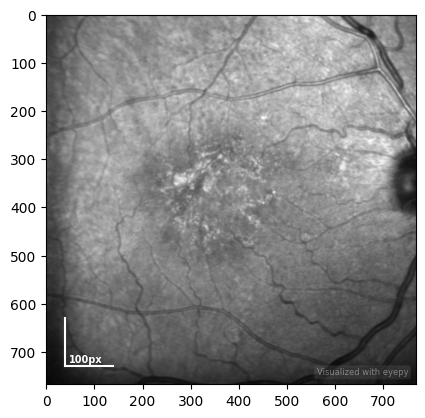

In [6]:
import eyepy as ep
# Import HEYEX E2E export -> Try with one OCT from a patient in proprietary format.
ev = ep.import_heyex_e2e(r"C:\Users\camil\Downloads\Test_data_OCT\Zip_patients_E2E\01_2442\01_2442\244253_.E2E")
ev.plot()

In [7]:
ev.shape

(31, 496, 512)

First dimension (31):
Represents the number of slices or B-scans (cross-sectional images) in the volumetric data. These are acquired along the depth axis of the scanned region.

Second dimension (496):
Represents the number of pixels in the vertical direction of each slice, corresponding to the depth of the tissue being imaged.

Third dimension (512):
Represents the number of pixels in the horizontal direction of each slice, corresponding to the lateral extent of the imaged area.

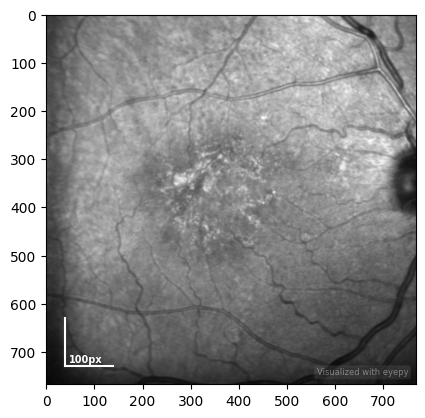

In [8]:
#Most OCT volumes come with a localizer image. This image can be plotted using the plot method of the EyeVolume object:
ev.plot()
#This function plots an annotated OCT localizer image.

In [59]:
ev.shape

(145, 496, 512)

Plot Bscans: B-scans can be plotted using the plot method of the EyeBscan object. You get ´EyeBscan´ objects by indexing the ´EyeVolume´ object or iterating over it. The following code plots the first B-scan of the volume together with the layer annotations for BM and RPE:

KeyError: 'RPE'

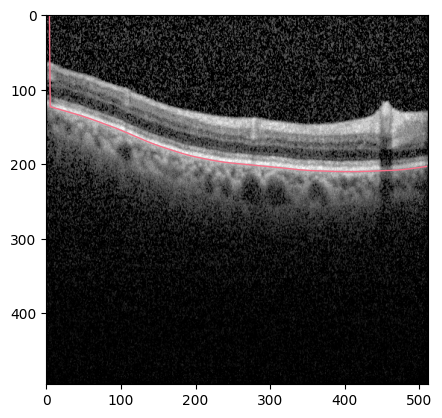

In [9]:
ev[0].plot(layers=["BM", "RPE"])